# Задание

Zestimate Home занимаются оценкой стоимости недвижимости.   

«Zestimates» - это оценочные значения стоимости дома, основанные на 7,5 миллионах статистических моделей и моделей машинного обучения, которые анализируют сотни точек данных по каждому объекту недвижимости.

Есть данные об ошибке их прогноза

𝑙𝑜𝑔𝑒𝑟𝑟𝑜𝑟 = 𝑙𝑜𝑔 (𝑍𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒) −𝑙𝑜𝑔 (𝑆𝑎𝑙𝑒𝑃𝑟𝑖𝑐𝑒)

Мы хотим спрогнозировать logerror.



# Будем проверять гипотезу о связи плотности участков

Высокая плотность участков указывает на большое количество точек данных в его географическом регионе.   
Эта  'плотность' вокруг участка может быть связана с прогнозируемой нами логической ошибкой, поскольку производительность модели (т.е. логарифмическая ошибка) обычно зависит от количества репрезентативных данных, на которых она была обучена.    
Поэтому проверим следующую гипотезу:

<h3> Гипотеза: более высокая плотность участков связана с меньшей абсолютной логической ошибкой. </h3>
<p> </p>
<p> </p>


Давайте начнем!


# 1. Импорт

In [ ]:
!pip install catboost -q

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity, KDTree
from scipy.stats import pearsonr
from scipy.stats import rankdata

import seaborn as sns

# Данные

In [ ]:
#В колабе импортируем все необходимые библиотеки
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Привязываем гуглдиск к колабу
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Загружаем файл в колаб
download = drive.CreateFile({"id": "1QYTBBEoK4T_pyIfhFZMnm6bKWUBaPumD"})
# https://drive.google.com/file/d/1QYTBBEoK4T_pyIfhFZMnm6bKWUBaPumD/view?usp=sharing
download.GetContentFile("train_2016_v2.zip")

download = drive.CreateFile({"id": "1JLSWg_yLH73wn-Ln-z1tJZ1S3pz3N9Nq"})
# https://drive.google.com/file/d/1JLSWg_yLH73wn-Ln-z1tJZ1S3pz3N9Nq/view?usp=drive_link
download.GetContentFile("properties_2016.csv")

In [ ]:
train2016 = pd.read_csv('train_2016_v2.zip')
props = pd.read_csv('properties_2016.csv',low_memory=False)
train_ = train2016.merge(props,how='left',on='parcelid')
train_.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


Поскольку мы хотим знать взаимосвязь между логарифмической ошибкой и плотностью участков, для анализа нам нужны только строки из обучающего набора, содержащие координаты x, y.

In [ ]:
# train = train_[['parcelid','longitude','latitude','logerror']]
train = train_[['longitude','latitude','logerror']]
train.dropna(inplace=True)
display(train.head())
print("shape = ",train.shape)

<ipython-input-30-1cb2049538c7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace=True)


,longitude,latitude,logerror
0,-118488536.0,34280990.0,0.0276
1,-117677556.0,33668120.0,-0.1684
2,-118175032.0,34136312.0,-0.0040
3,-118309000.0,33755800.0,0.0218
4,-117700234.0,33485643.0,-0.0050


shape =  (90275, 3)


В нашем наборе 90275 наблюдений.

# 2. Восстановление распределения
«Оценка ядерной плотности» или KDE.  
Он оценивает функцию плотности вероятности по заданным точкам данных.     
В нашем случае эти точки данных являются географическими координатами участков.



Будем использовать гауссовское ядро.
![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/2a/Kernel_density.svg/250px-Kernel_density.svg.png)

Для оптимизации  производительности  функции зададим некоторые параметры для KDTree

In [ ]:
def get_pde(train,bw):
    """Функция для восстановления распределения плотности вероятности

    Args:
          train: Данные
          bw: Ширина окна. Большая полоса пропускания приводит к очень плавному
          (т.е. с большим смещением) распределению плотности. Небольшая полоса
          пропускания приводит к негладкому (т.е. с высокой дисперсией) распределению плотности.

Параметр bandwidth управляет этим сглаживанием.
    Returns:
       ndarray: Оценка плотности распределения в каждой точке
    """
    x = train['longitude'].values
    y = train['latitude'].values
    xy = np.vstack([x,y])
    X = np.transpose(xy)
    # используем для оценки плотности распределения K-мерное дерево
    tree = KDTree(X,leaf_size = 20)
    #rtol - относительная разница при которой массивы считаются разными
    parcelDensity = tree.kernel_density(X, h=bw, kernel='gaussian',rtol=0.00001)
    # используем для оценки плотности распределения  KernelDensity
    # kde = KernelDensity(kernel='gaussian', bandwidth=bw,rtol=0.00001).fit(X)
    # parcelDensity = kde.score_samples(X)
    return parcelDensity

In [ ]:
parcelDensity30000 = get_pde(train,30000)
parcelDensity1000 = get_pde(train,1000)
parcelDensity300 = get_pde(train,300)


In [ ]:
parcelDensity30000[:10]

array([1.37478903e-07, 1.49513306e-07, 1.90540355e-07, 1.37635374e-07,
       1.48392261e-07, 1.72136838e-07, 1.57392281e-07, 9.93119534e-08,
       2.20990586e-07, 1.93930329e-07])

# 2.1 Визуализация плотности участков с шириной окна 30 000
Давайте визуализируем результаты нашего KDE в виде диаграммы разброса.     
Используем долготу и широту наших участков как координаты x, y и раскрасим эти точки по их плотности.   
На графике четко показаны наиболее плотные области ярко-желтым цветом, более полуцентральные участки - оранжевым, периферийные участки - фиолетовым, а относительно изолированные места - черным.

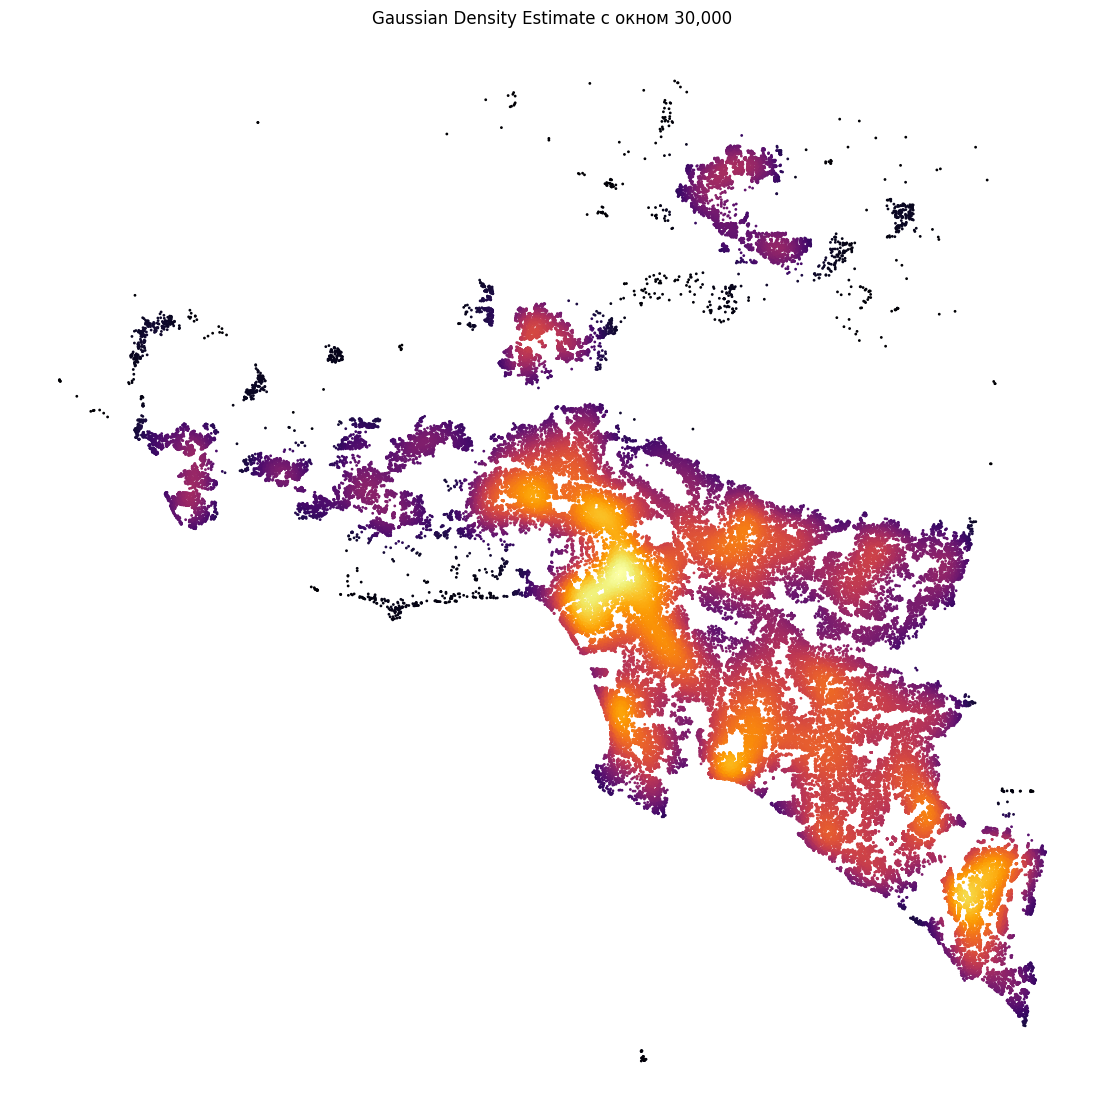

In [ ]:
plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Gaussian Density Estimate с окном 30,000")
plt.scatter(x=train['longitude'].values, y=train['latitude'].values, c=parcelDensity30000,cmap='inferno', s=1)


Ярко-желтая плотная область на карте почти идеально сочетается с тем, что Google Maps определяет как центр Лос-Анджелеса. Это означает, что функция плотности участков теперь содержит информацию о центральности определенного участка.
https://www.google.nl/maps/place/Downtown,+Los+Angeles,+CA,+USA/@33.9761623,-118.5305526,10z/data=!4m5!3m4!1s0x80c2c634253dfd01:0x26fe52df19a5a920!8m2!3d34.040713!4d-118.2467693

# 2.2 Визуализация плотности участков с шириной окна 1000 и 300
В KDE с меньшим размером окна локальные колебания относительно сильны и не могут вызвать выбросы, которые превосходят «нормальные» колебания в KDE на изображении графика.  
Чтобы улучшить видимость умеренных колебаний, оценим KDE для этих графиков по их процентилям.

In [ ]:
rankScaled30000 = 100*rankdata(parcelDensity30000)/len(parcelDensity30000)
rankScaled1000 = 100*rankdata(parcelDensity1000)/len(parcelDensity1000)
rankScaled300 = 100*rankdata(parcelDensity300)/len(parcelDensity300)

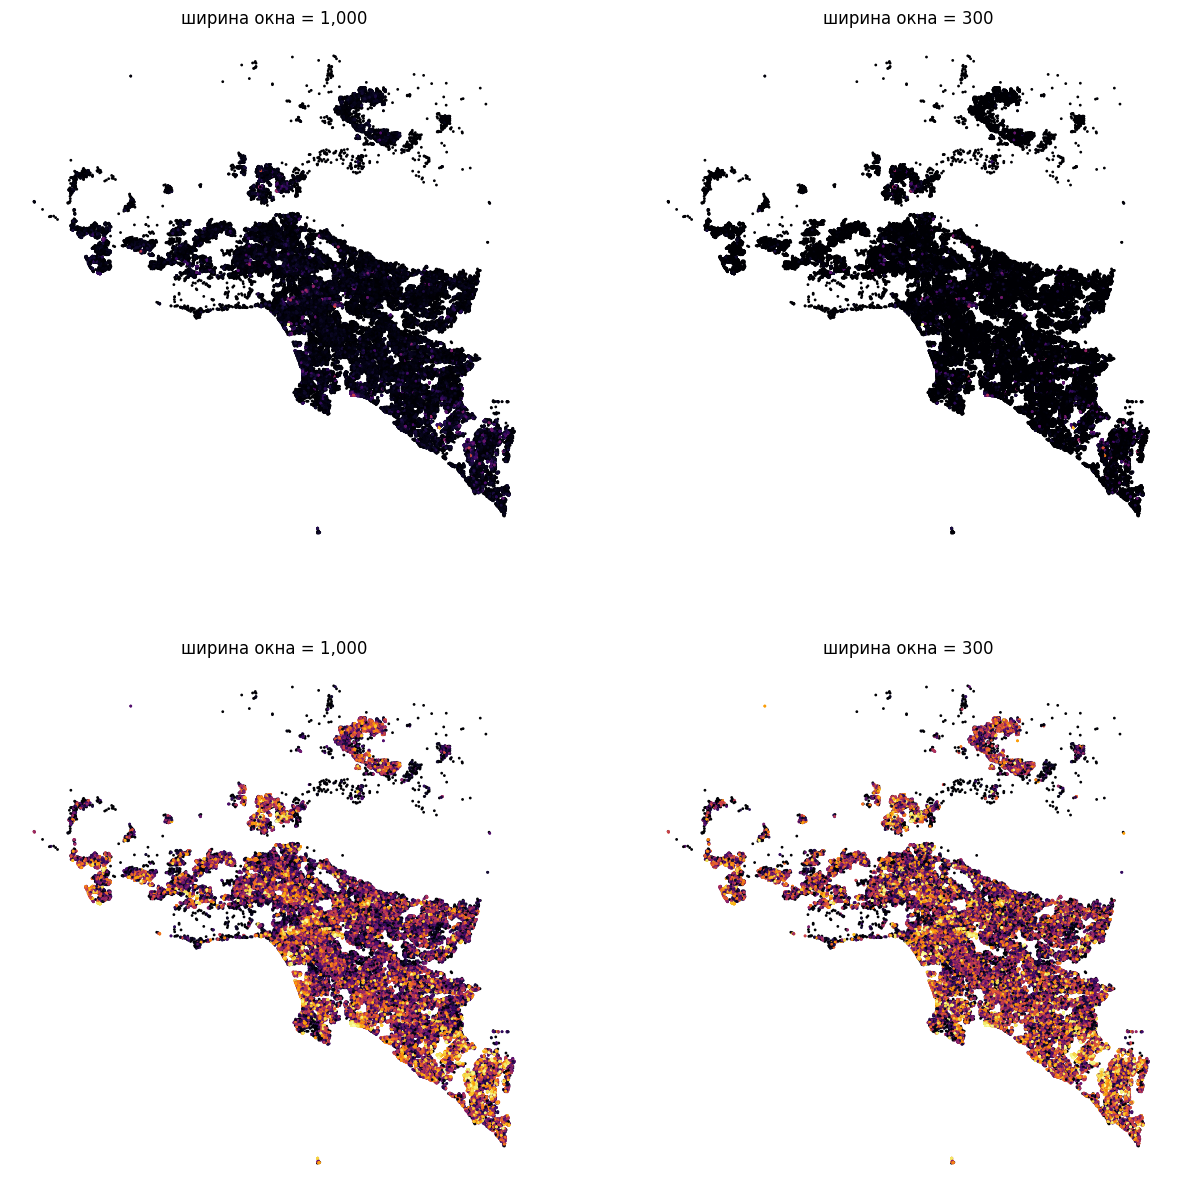

In [ ]:
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(221)
ax1.set_title('ширина окна = 1,000')
ax1.set_axis_off()
ax1.scatter(train['longitude'].values, train['latitude'].values, c=parcelDensity1000,cmap='inferno', s=1)

ax2 = fig.add_subplot(222)
ax2.set_title('ширина окна = 300')
ax2.set_axis_off()
ax2.scatter(train['longitude'].values, train['latitude'].values, c=parcelDensity300,cmap='inferno', s=1)


ax3 = fig.add_subplot(223)
ax3.set_title('ширина окна = 1,000')
ax3.set_axis_off()
ax3.scatter(train['longitude'].values, train['latitude'].values, c=rankScaled1000,cmap='inferno', s=1)

ax4 = fig.add_subplot(224)
ax4.set_title('ширина окна = 300')
ax4.set_axis_off()
ax4.scatter(train['longitude'].values, train['latitude'].values, c=rankScaled300,cmap='inferno', s=1)



# 3. Результаты
Мы хотим проверить, связаны ли более высокие значения KDE с более низкими абсолютными ошибками.   
Поэтому мы хотим сравнить KDE с абсолютной ошибкой logerror.    

 Измерим корреляцию Пирсона для 3 размеров окна.

# 3.1 Результат окна 30 000
Подробно рассмотрим результаты для окна 30 000.

In [ ]:
abs_logerrors = np.abs(train['logerror'].values)

In [ ]:
corrCoef_30000, _ = pearsonr(parcelDensity30000,abs_logerrors)

print("Результат для окна 30,000:", corrCoef_30000)

Результат для окна 30,000: 0.009403149426778012


Вывод: нет значимой отрицательной корреляции между функцией плотности и абсолютной логической ошибкой с окном 30 000.


# 3.2 Результаты для окон 1000 и 300


In [ ]:
corrCoef_1000, _ = pearsonr(parcelDensity1000,abs_logerrors)
corrCoef_300, _ = pearsonr(parcelDensity300,abs_logerrors)

print("для окна 1,000, Correlation Coefficient: ",corrCoef_1000)
print()
print("для окна 500, Correlation Coefficient: ",corrCoef_300)

для окна 1,000, Correlation Coefficient:  -0.041033211208777315

для окна 500, Correlation Coefficient:  -0.030445399644073952


Вывод: для 1,000 и 300 существует значительная отрицательная корреляция между KDE и абсолютной логической ошибкой.  
Это значит, что высокое значение плотности и низкая логическая ошибка связаны, что подтверждает выдвинутую гипотезу.

# 4. Заключение  
Результат показывает, что более высокая плотность связана с меньшими абсолютными ошибками.   
Эта гипотеза подтвердилась для окон 1000 и 300.   
Неожиданно противоположная зависимость наблюдалась для  30 000.

В целом, это означает, что плотность участков может быть полезным признаком для прогнозирования логической ошибки Zestimate и ее добавление может значительно улучшить результаты предсказаний, и на примере Zestimate, поможет им делать более точные прогнозы.


In [ ]:
# Удалим дубликаты
train_.drop_duplicates ()
train_.shape

(90275, 60)

In [ ]:
cat_features = [i for i in train_.columns if train_[i].dtype not in ['float64','int64']]
cat_features

['transactiondate',
 'hashottuborspa',
 'propertycountylandusecode',
 'propertyzoningdesc',
 'fireplaceflag',
 'taxdelinquencyflag']

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
cbr = CatBoostRegressor(cat_features=cat_features, iterations=200, random_state=42)

X = train_.drop(['logerror'], axis = 1)
X[cat_features] = X[cat_features].fillna("")
y = train_['logerror']*100
scores = -np.mean(cross_val_score(cbr, X, y, cv=3, scoring='neg_mean_absolute_error'))
scores

Learning rate set to 0.289467
0:	learn: 15.2670682	total: 141ms	remaining: 28.1s
1:	learn: 15.2407607	total: 229ms	remaining: 22.6s
2:	learn: 15.2256536	total: 305ms	remaining: 20s
3:	learn: 15.2029695	total: 396ms	remaining: 19.4s
4:	learn: 15.1878066	total: 472ms	remaining: 18.4s
5:	learn: 15.1770020	total: 550ms	remaining: 17.8s
6:	learn: 15.1564519	total: 622ms	remaining: 17.2s
7:	learn: 15.1428355	total: 698ms	remaining: 16.8s
8:	learn: 15.1280360	total: 781ms	remaining: 16.6s
9:	learn: 15.1179850	total: 850ms	remaining: 16.1s
10:	learn: 15.1129472	total: 936ms	remaining: 16.1s
11:	learn: 15.0946243	total: 1.02s	remaining: 16s
12:	learn: 15.0884720	total: 1.11s	remaining: 16s
13:	learn: 15.0764609	total: 1.2s	remaining: 15.9s
14:	learn: 15.0742329	total: 1.25s	remaining: 15.4s
15:	learn: 15.0712226	total: 1.33s	remaining: 15.3s
16:	learn: 15.0619443	total: 1.39s	remaining: 15s
17:	learn: 15.0480128	total: 1.47s	remaining: 14.9s
18:	learn: 15.0346188	total: 1.54s	remaining: 14.7s
1

7.092218861783432

In [ ]:
scores

7.092218861783432

In [ ]:
train_2 = pd.concat([train_,
                     pd.DataFrame([parcelDensity1000,
                                   parcelDensity300]).T],
                    axis = 1)

In [ ]:
cbr = CatBoostRegressor(cat_features=cat_features, iterations=200, random_state=42)

X = train_2.drop(['logerror'], axis = 1)
X[cat_features] = X[cat_features].fillna("")
y = train_['logerror'] * 100
scores = -np.mean(cross_val_score(cbr, X, y, cv=3, scoring='neg_mean_absolute_error'))
scores

Learning rate set to 0.289467
0:	learn: 15.2675578	total: 74ms	remaining: 14.7s
1:	learn: 15.2455291	total: 145ms	remaining: 14.4s
2:	learn: 15.2277101	total: 237ms	remaining: 15.6s
3:	learn: 15.2032315	total: 333ms	remaining: 16.3s
4:	learn: 15.1876962	total: 407ms	remaining: 15.9s
5:	learn: 15.1744144	total: 478ms	remaining: 15.5s
6:	learn: 15.1613946	total: 552ms	remaining: 15.2s
7:	learn: 15.1466673	total: 628ms	remaining: 15.1s
8:	learn: 15.1377268	total: 705ms	remaining: 15s
9:	learn: 15.1292517	total: 788ms	remaining: 15s
10:	learn: 15.1188664	total: 869ms	remaining: 14.9s
11:	learn: 15.1031736	total: 942ms	remaining: 14.8s
12:	learn: 15.0862562	total: 1.02s	remaining: 14.6s
13:	learn: 15.0806976	total: 1.08s	remaining: 14.3s
14:	learn: 15.0701308	total: 1.16s	remaining: 14.3s
15:	learn: 15.0590266	total: 1.24s	remaining: 14.3s
16:	learn: 15.0478651	total: 1.33s	remaining: 14.3s
17:	learn: 15.0295988	total: 1.41s	remaining: 14.2s
18:	learn: 15.0131650	total: 1.48s	remaining: 14.

7.047694328204322

In [ ]:
scores

7.047694328204322

Даже на неподготовленных данных видно снижение абсолютной ошибки прогноза.